In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
staticfile = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
surfdatfile = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clmsurffile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'

In [3]:
ds_static = xr.open_dataset(staticfile)
ds_surf = xr.open_dataset(surfdatfile)
ds_clmsurf = xr.open_dataset(clmsurffile)

## Questions
1. Does the mask need to be T/F or 0/1 for xesmf regridding?
2. Do the mask Lat/Lon need to be aligned (i.e. both 0 -> 360) or can xesmf convert on the fly?
3. Should the clmsurfdat use the static icwtr mask or should it use it's own PCT_NATVEG (like the target regrid file)?

## Answers

### 1. It seems like we need to mask to avoid including NaNs:

> By default, xESMF treats NaNs like regular values hence potentially resulting in missing values bleeding into the regridded field and creating insconsistencies in the resulting masked array.

xESMF examples use `1/0` values where the `NaN` are to mask

> `ds["mask"] = xr.where(~np.isnan(ds["zeta"].isel(ocean_time=0)), 1, 0)`

The `Regridder` reference states that it wants 1, 0 explicitly.  That said, does as T/F mask convert automatically?

> All variables that the cf-xarray accessor understand are accepted. Otherwise, look for lon, lat, optionally lon_b, lat_b for conservative methods, and mask. **Note that for mask, the ESMF convention is used, where masked values are identified by 0, and non-masked values by 1.** (emphasis mine)

Also of note; providing bounds is ideal for conservative regridding:
> For conservative methods, if bounds are not present, they will be computed using cf-xarray (only 1D coordinates are currently supported).

## Ice water as mask

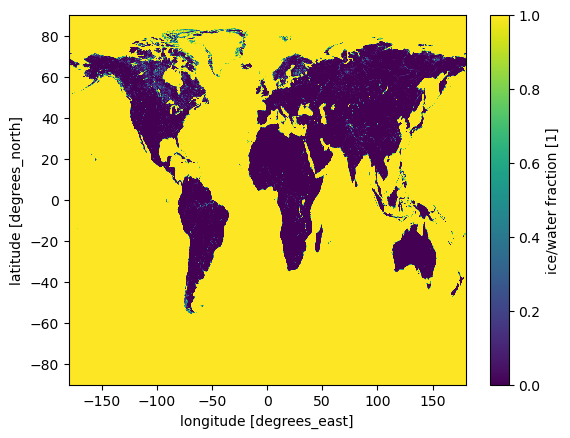

In [4]:
icwtr = ds_static.icwtr.astype('float64')
icwtr.plot()

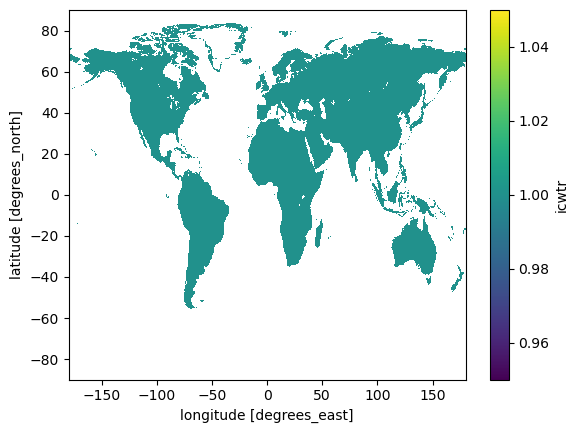

In [5]:
mask_static_ratio = (1-icwtr) / (1-icwtr)
mask_static_ratio.plot()

### Check to see if all the data is 1/0 or NaN
Convert to dataframe to make use of `dropna`

In [6]:
mask_static_ratio

<xarray.DataArray 'icwtr' (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88

In [7]:
(mask_static_ratio.to_dataframe().dropna() != 1.).any()

icwtr    False
dtype: bool

In [8]:
(mask_static_ratio.to_dataframe().dropna() == 1.).all()

icwtr    True
dtype: bool

**Conclusion:** It looks like all the data is either 1 or NaN

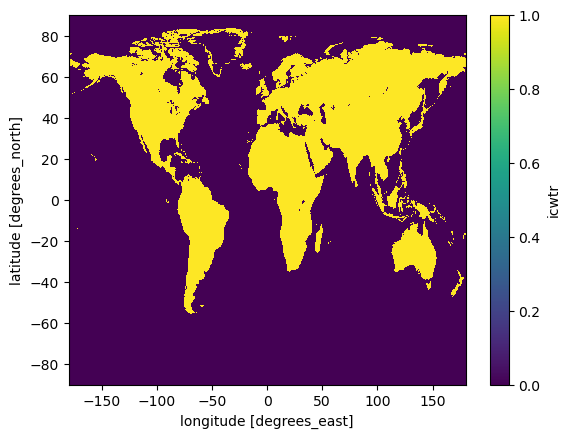

In [9]:
mask_static_icwtr_not = (icwtr != 1)
mask_static_icwtr_not.plot()

### Even though the plot shows 1.0 and 0.0, the data is really T/F per below

In [16]:
mask_static_icwtr_not

<xarray.DataArray 'icwtr' (lat: 720, lon: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88

### We can use the `where` function to make sure we get 1/0

In [53]:
mask_static_icwtr_not_nan = xr.where(icwtr != 1.,1,0)
print(mask_static_icwtr_not_nan)

<xarray.DataArray 'icwtr' (lat: 720, lon: 1440)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88


### Check to see if the two icwtr based masks are the same

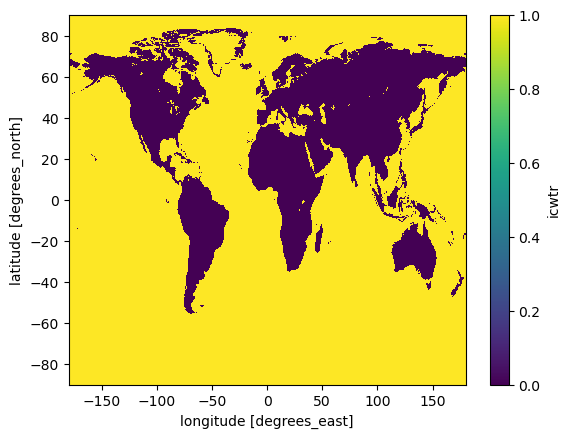

In [54]:
comp_mask_static = xr.where(mask_static_icwtr_not_nan == mask_static_ratio,0,1)
comp_mask_static.plot()

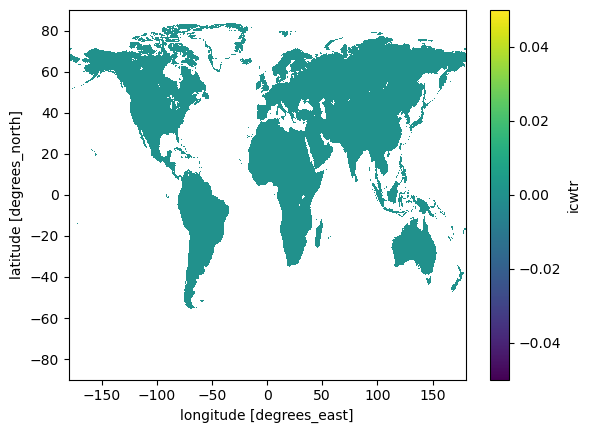

In [55]:
diff_mask_static = mask_static_icwtr_not_nan - mask_static_ratio
diff_mask_static.plot()

In [60]:
diff_mask_static.to_dataframe().dropna().sum()

icwtr    0.0
dtype: float64

### Since the sum of the mask is zero, the two are equivalent
Note that I had to drop `NaN`s due to them coming in with the `mask_static_ratio` calculation.  As a reminder, no two nans are equivalent.

In [20]:
np.NaN == np.NaN

False

**Conclusion:** I forgot that no two nans are equivalent.

## Surface dataset PCT_NATVEG as mask

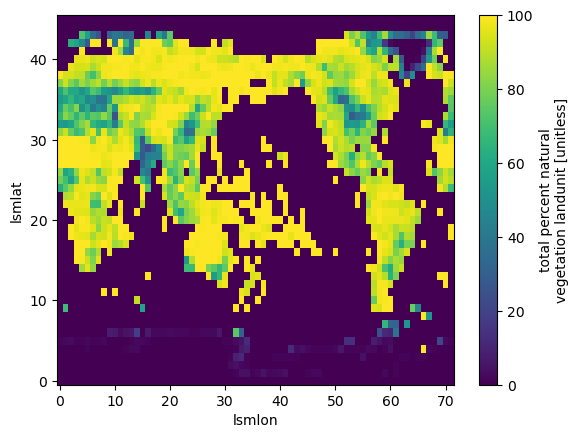

In [21]:
ds_surf.PCT_NATVEG.plot()

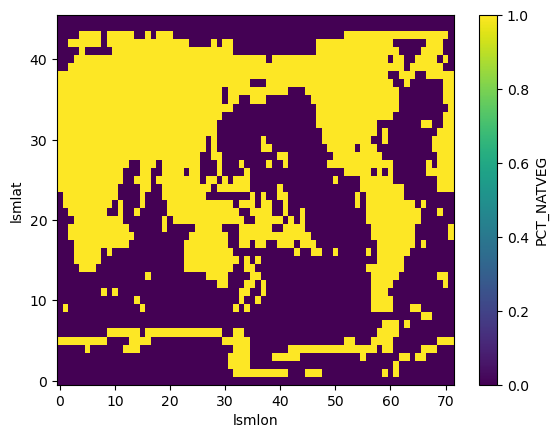

In [22]:
mask_surf = ds_surf.PCT_NATVEG > 0
mask_surf.plot()

### Again the values are T/F, not 1/0/NaN

In [15]:
mask_surf

<xarray.DataArray 'PCT_NATVEG' (lsmlat: 46, lsmlon: 72)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: lsmlat, lsmlon

### Convert to 1/0

In [65]:
mask_surf_new = xr.where(mask_surf,1,0)

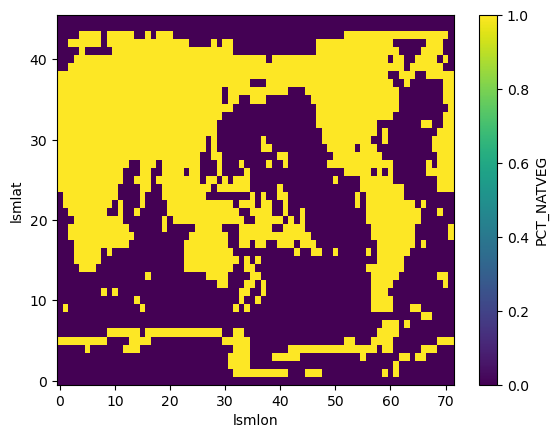

In [66]:
mask_surf_new.plot()

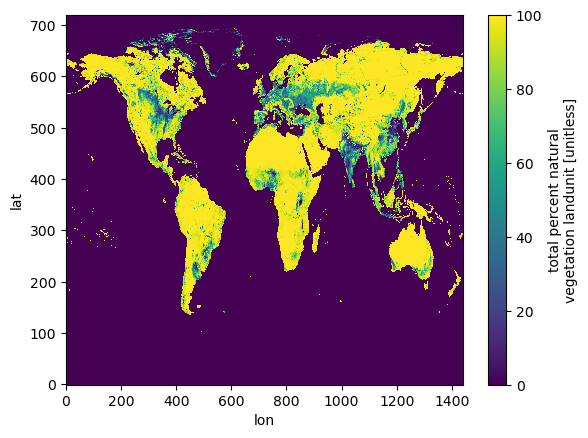

In [27]:
ds_clmsurf.PCT_NATVEG.plot()

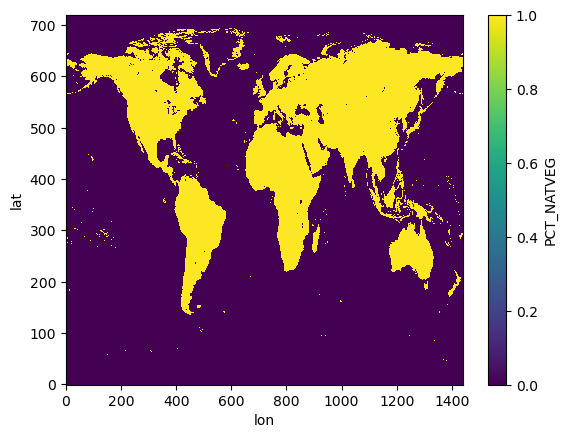

In [28]:
mask_clmsurf = ds_clmsurf.PCT_NATVEG > 0
mask_clmsurf.plot()

In [29]:
mask_clmsurf

<xarray.DataArray 'PCT_NATVEG' (lat: 720, lon: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: lat, lon

In [30]:
mask_clmsurf_nan = xr.where(mask_clmsurf,1,np.NaN)

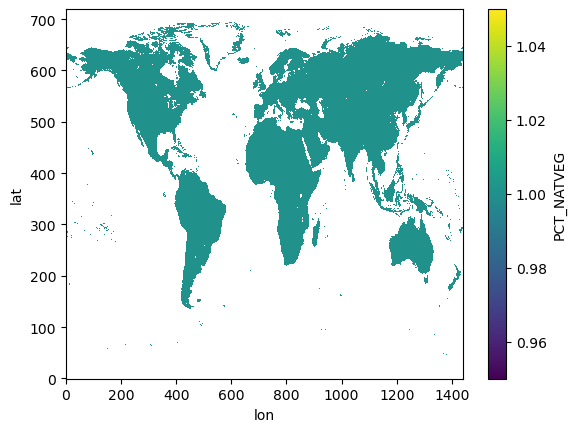

In [31]:
mask_clmsurf_nan.plot()

## Converting and Aligning coordinates

### static (and all luh2?) data

The static data uses -180:180 convention.  The data has coordinates and dimension names that align (i.e. "lat/lon")

In [50]:
ds_static

<xarray.Dataset>
Dimensions:     (lon: 1440, lat: 720, bounds: 2)
Coordinates:
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Dimensions without coordinates: bounds
Data variables:
    ptbio       (lat, lon) float32 ...
    fstnf       (lat, lon) float32 ...
    carea       (lat, lon) float32 ...
    icwtr       (lat, lon) float32 ...
    ccode       (lat, lon) float32 ...
    lat_bounds  (lat, bounds) float32 ...
    lon_bounds  (lon, bounds) float32 ...
Attributes: (12/17)
    history:           Processed: 2016-10-12T14:10:57Z
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016 10 12 14:10
    title:             Land Use Data Sets
    ...                ...
    license:           MIT
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    instituition:      University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [40]:
ds_static.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    _fillvalue:     1e+20
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

There are bounds available in the variables.  

In [51]:
ds_static.lon_bounds

<xarray.DataArray 'lon_bounds' (lon: 1440, bounds: 2)>
[2880 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds

### Surface data set (regrid target)

The surface dataset does has dimensions "lsmlat/lsmlon", but does not have coordinates that align.  There are no lat/lon coordinates.

In [49]:
ds_surf

<xarray.Dataset>
Dimensions:                  (lsmlat: 46, lsmlon: 72, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/88)
    mxsoil_color             int32 20
    SOIL_COLOR               (lsmlat, lsmlon) int32 10 10 10 10 ... 15 15 15 15
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 43.0 ... 43.0
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 18.0 ... 18.0
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 0.0 0.0 ... 0.0
    FMAX                     (lsmlat, lsmlon) float64 0.3902 0.3902 ... 0.3658
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 0.0 0.0 0.0 ... 0.0 0.0
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 0.0 0.0 0.0 ... 0.0 0.0
    CONST_GRAZING            (lsmlat, lsmlon) float64 -9.999e+03 ... 0.0
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 0.0 0.0 ... 0.0 0.0
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 0.0 0.0 ... 0.0
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 0.0 0.0 ... 0.0 0.0
Attributes: (12/53)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 08-24-17 14:43:08
    Logname:                              erik
    Host:                                 cheyenne1
    Source:                               Community Land Model: CLM4
    Version:                              $HeadURL: https://svn-ccsm-models.c...
    ...                                   ...
    map_ch4_params_file:                  map_360x720_cruncep_to_4x5_nomask_a...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

In [42]:
ds_surf.lsmlon

<xarray.DataArray 'lsmlon' (lsmlon: 72)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])
Dimensions without coordinates: lsmlon

In [44]:
ds_surf.LONGXY

<xarray.DataArray 'LONGXY' (lsmlat: 46, lsmlon: 72)>
array([[  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       ...,
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.]])
Dimensions without coordinates: lsmlat, lsmlon
Attributes:
    long_name:  longitude
    units:      degrees east

In [38]:
mask_static_icwtr_not_nan.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875])
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    _fillvalue:     1e+20
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X